In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame
# from MyLearner import MyLearner

# from MyScorer import MyScorer
# from MyPlotter import MyPlotter

import pandas as pd
import numpy as np
import string
import itertools

import math
import scipy.stats as sts
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics

import seaborn as sns
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import ensemble as ens
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.model_selection as model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_val_score
import sklearn.feature_selection as feature_selection
import sklearn.preprocessing as prepc
from sklearn.multiclass import OneVsRestClassifier as ovr
from sklearn.multiclass import OneVsOneClassifier as ovo
from sklearn.multiclass import OutputCodeClassifier as occ
import sklearn
import sklearn.metrics as metrics
from rfpimp import dropcol_importances
from rfpimp import importances
import imblearn.over_sampling as imbOVS
import imblearn.under_sampling as imbUDS
import imblearn.combine as imbCMB

from dabl.plot import class_hists

c:\00_data\python38\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#import train dataset
filename_tr = 'train.csv'
data_train = pd.read_csv(filename_tr)

#import test dataset
filename_tes = 'test.csv'
data_test = pd.read_csv(filename_tes)

### Training Set

In [3]:
data_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Test Set

In [4]:
data_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Checking missing values in training set

In [5]:
nulls = data_train.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
N = len(data_train.index)
nulls.insert(1, 'percent', ['{0:.2%}'.format(nulls.loc['Age'][0] / N), 
                            '{0:.2%}'.format(nulls.loc['Cabin'][0] / N),
                            '{0:.2%}'.format(nulls.loc['Embarked'][0] / N)])
nulls

,count,percent
Age,177,19.87%
Cabin,687,77.10%
Embarked,2,0.22%


Seems to be a lot of missing values in 'Age' and 'Cabin'.

As I concluded from preliminary analysis, the Age is one of the critical and must be treated first.

The Cabin and Embarked are probably not important in Survival prediction.

I will come to nulls later but for now lets look on distributions.

### Checking missing values in test set

In [6]:
nulls = data_test.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
nulls

,count
Age,86
Fare,1
Cabin,327


#### Calculate survival rate

In [7]:
#how many died
N_surv0 = len(data_train.loc[data_train['Survived']==0])
#how many survived
N_surv1 = len(data_train.loc[data_train['Survived']==1])

print('Deads: {0} ({1:.2%})'.format(N_surv0, N_surv0 / N))
print('Survivals: {0} ({1:.2%})'.format(N_surv1, N_surv1 / N))

Deads: 549 (61.62%)
Survivals: 342 (38.38%)


Well, only 1/3 survived. That was expectable though.

In [8]:
data = data_train[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

#encode categorical variables
df1 = data['Sex'].apply(lambda i: 1 if i=='male' else 0)
df2 = data['Embarked'].apply(lambda i: 0 if i=='C' else (1 if i=='Q' else 2))
data = pd.concat([data.drop(columns=['Sex', 'Embarked']), df1, df2], axis=1)

#add family size
data['famsize'] = data['SibSp'] + data['Parch']

#numerical data
data_num = data[['Age', 'Fare',]]

#categorical data
data_cat = data[['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch', 'famsize']]

In [9]:
data.head(5)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked,famsize
0,0,3,22.0,1,0,7.2500,1,2,1
1,1,1,38.0,1,0,71.2833,0,0,1
2,1,3,26.0,0,0,7.9250,0,2,0
3,1,1,35.0,1,0,53.1000,0,2,1
4,0,3,35.0,0,0,8.0500,1,2,0


### Plotting Variables

In [10]:
def plot_bar_diagram(ax, data, nested=False, plots_labels=None, plots_colors=None, bar_labels='', width=0.4, title='', length_label='',
                     orient='v', legend_loc=None, spines=None):
    """
    Plots single or multiple bar diagrams with data labels on top(aside) of the bars
    :param ax: matplotlib axes
    :param data: pandas DataFrame where rows correspond to bar plots and columns correspond to data labels (columns in data)
    :param nested: boolean. If True, bar plots are plotted on top of each other. If False bar plots are plotted besides each other
    :param bar_labels: pandas DataFrame. labels over the bars. Should be same shape as data
    :param width: float. Bar width
    :param title: string. Plot title
    :param length_label: bar height/width axis label
    :param spines: dictionary of booleans. indicates to plot borders or not. Keys=['left', 'right', 'top', 'bottom'], values=True/False
    :param orient: string. Bar orientation: 'v'-vertical; 'h'-horisontal
    """
    bars = list(data.index)
    cols = list(data.columns)
    cells = data.values.tolist()

    if bar_labels is not None:
        for i, lab in enumerate(bars):
            labels = ([f"{j:.4f}" for j in cells[i]] if bar_labels=='' else bar_labels[i])

    if orient == 'v':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            color = ('r' if plots_colors is None else plots_colors[i])
            x = np.arange(len(cols))
            bar = ax.bar(x=x + width * (i - len(bars) / 2), height=cells[i], width=width,
                         label=label,
                         color=color,
                         align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='v')

        ax.set_xticks(np.arange(len(cols)))
        ax.set_xticklabels(cols)
        if not length_label=='':
            ax.set_ylabel(length_label)
    elif orient == 'h':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            y = np.arange(len(cols))
            height = width
            bar = ax.barh(y=y + height * (i - len(bars) / 2), width=cells[i], height=width,
                          label=label,
                          color=plots_colors[i],
                          align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='h')

        ax.set_yticks(np.arange(len(cols)))
        ax.set_yticklabels(cols)
        if not length_label=='':
            ax.set_xlabel(length_label)
    else:
        raise ValueError('orient parameter value error. expected v or h ')

    if not title == '':
        ttl = ax.title
        ttl.set_position([.5, 1.07])
        ax.set_title(title)
    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    else:
        ax.legend().set_visible(False)

    if spines is None:
        spines = {'left': True,
                  'right': True,
                  'top': True,
                  'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])

In [11]:
def autolabel(bars, ax, labels, oriented='v'):
    """Attach a text label displaying its height/width (depends of orientation)."""
    for bar, label in zip(bars, labels):
        if oriented == 'v':
            height = bar.get_height()
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha='center')
        else:
            width = bar.get_width()
            ax.annotate(label,
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(1, 0),
                        textcoords="offset points",
                        ha='left',
                        va='center')

In [12]:
def plot_correlation_matrix(ax, data, cmap='hot', diagonal=False, square=True):
    mask = None
    if diagonal:
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax,
                mask=mask,
                square=square,
                linewidths=1.5,
                cmap=cmap,
                cbar_kws={'shrink': 1, 'ticks': [-1, -.5, 0, 0.5, 1]},
                vmin=-1,
                vmax=1,
                annot=True,
                annot_kws={'size': 8})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

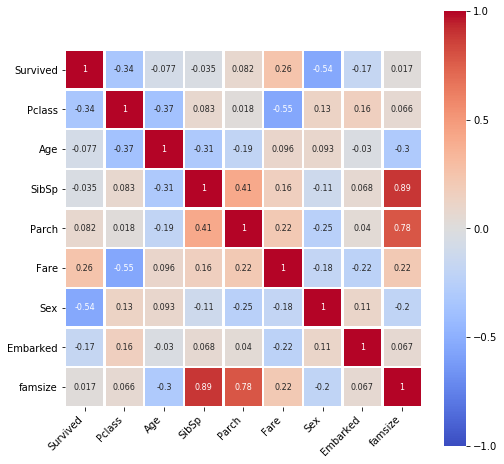

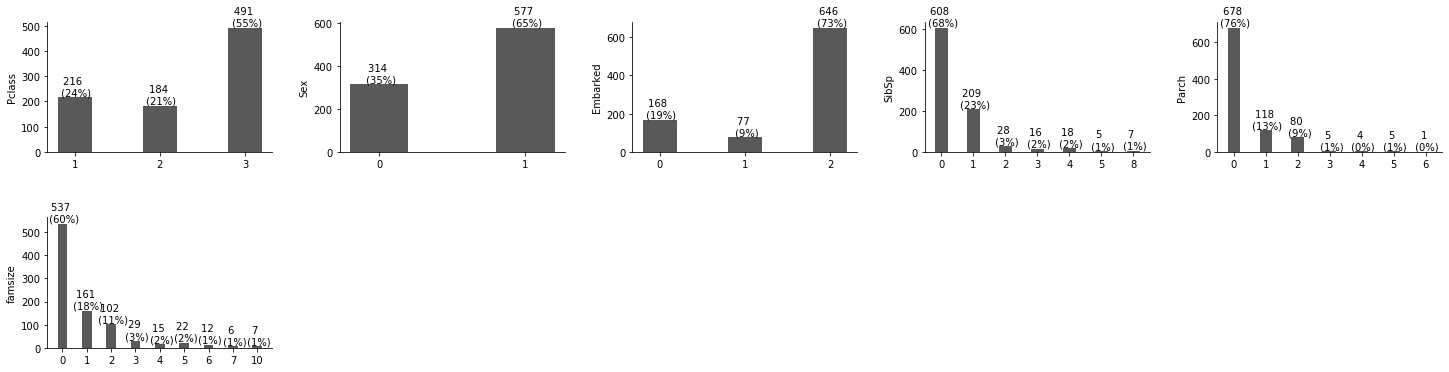

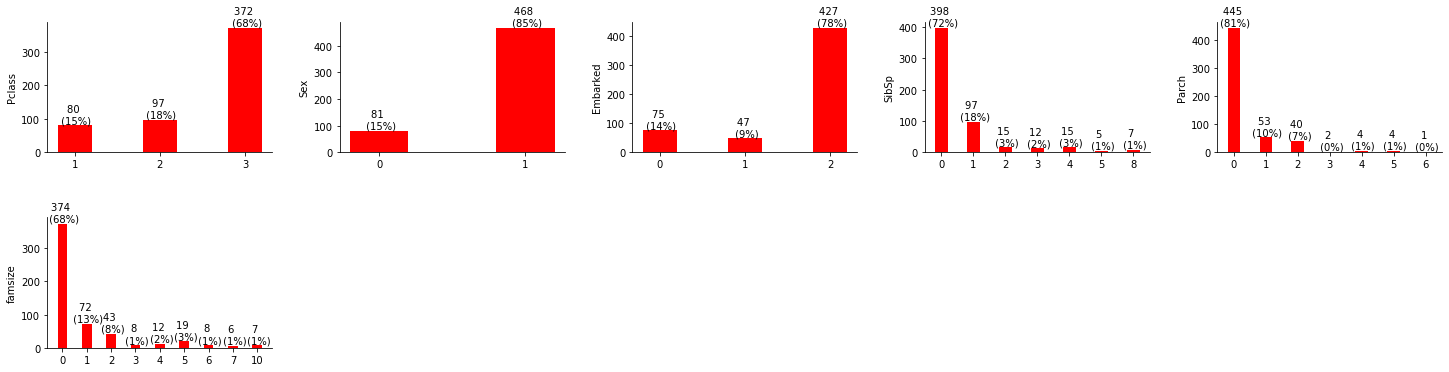

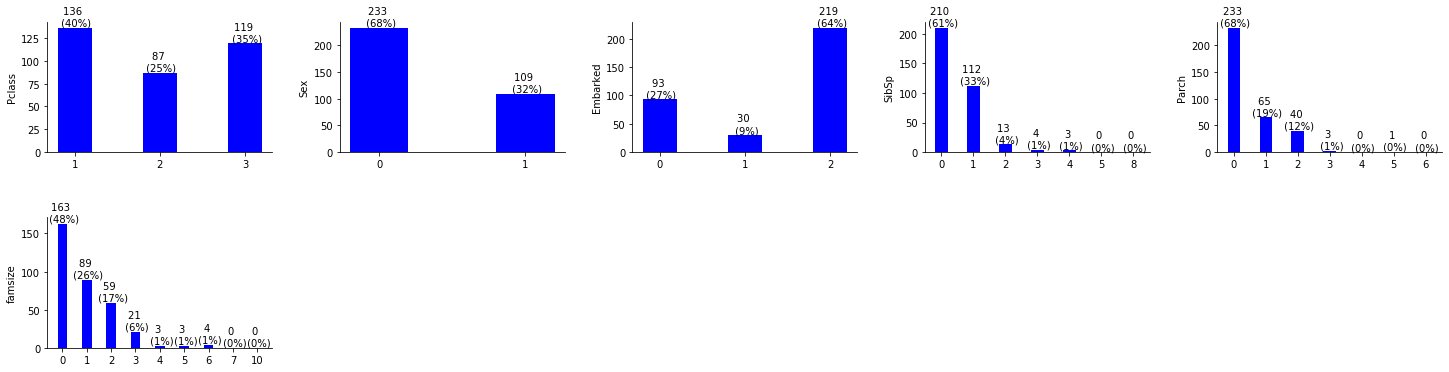

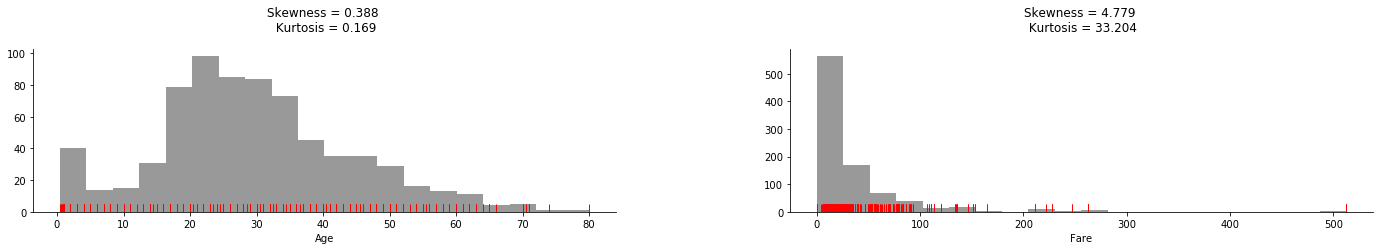

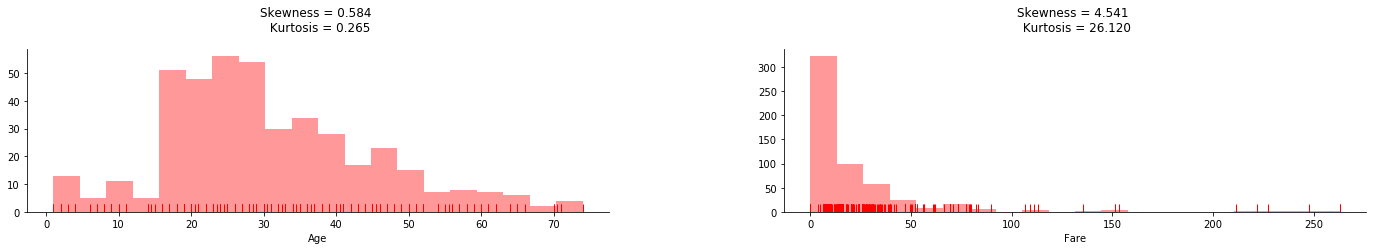

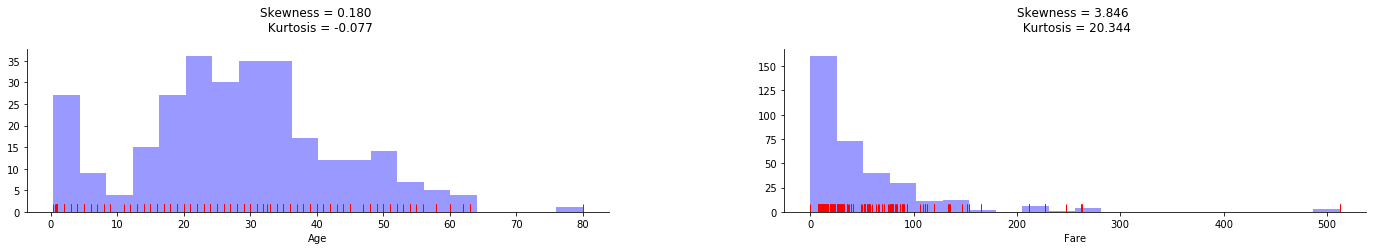

In [13]:
#plot correlation matrix
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap='coolwarm')


grd = list(data_cat.columns)
grd_n = len(grd)
grd_cols_n = 5
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 5

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n = len(data.loc[data[col]==i, col].index)
        fr = n / len(data.index)
        freq.append([n])
        frc.append([fr])

    df_freq = pd.DataFrame(freq, columns=['all'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['all'], index=data_cat[col].unique()).T
    labs = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['all'], df_frc.loc['all'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs],
                           plots_labels=None,
                           plots_colors=['0.35'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (non-survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n0 = len(data.loc[(data['Survived']==0) & (data[col]==i), col].index)
        fr0 = n0 / N_surv0
        freq.append([n0])
        frc.append([fr0])

    df_freq = pd.DataFrame(freq, columns=['non_survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['non_survivals'], index=data_cat[col].unique()).T
    labs0 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['non_survivals'], df_frc.loc['non_survivals'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs0],
                           plots_labels=None,
                           plots_colors=['r'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n1 = len(data.loc[(data['Survived']==1) & (data[col]==i), col].index)
        fr1 = n1 / N_surv1
        freq.append([n1])
        frc.append([fr1])

    df_freq = pd.DataFrame(freq, columns=['survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['survivals'], index=data_cat[col].unique()).T
    labs1 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['survivals'], df_frc.loc['survivals'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs1],
                           plots_labels=None,
                           plots_colors=['b'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    

    
grd = list(data_num.columns)
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data[col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "0"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (NON-SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==0, col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "r"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==1, col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))


#### Define age intervals using clastering

In [528]:
#Transform 'Age'
df_age = data_train['Age'].dropna()

age_trans = df_age.apply(lambda i: np.log(i+1)).to_frame()
age_trans.columns = ['Age_trans']
df_age = pd.concat([df_age.to_frame(), age_trans], axis=1)

In [529]:
#Define clustering model
age_cls_model = mix.BayesianGaussianMixture(n_components=2, covariance_type='spherical', tol=0.001, reg_covar=1e-06, max_iter=1000, n_init=1, 
                                 init_params='kmeans', weight_concentration_prior_type='dirichlet_distribution', 
                                 weight_concentration_prior=None, mean_precision_prior=None, mean_prior=None, 
                                 degrees_of_freedom_prior=None, covariance_prior=None, random_state=30)
                                 
#Predict class labels
age_cls = pd.DataFrame(age_cls_model.fit_predict(np.array(df_age['Age_trans']).reshape(-1,1)), columns=['Age_cls'])
age_cls = age_cls.astype(int)

In [530]:
df_age = pd.concat([df_age.reset_index(), age_cls], axis=1).drop(columns='index')

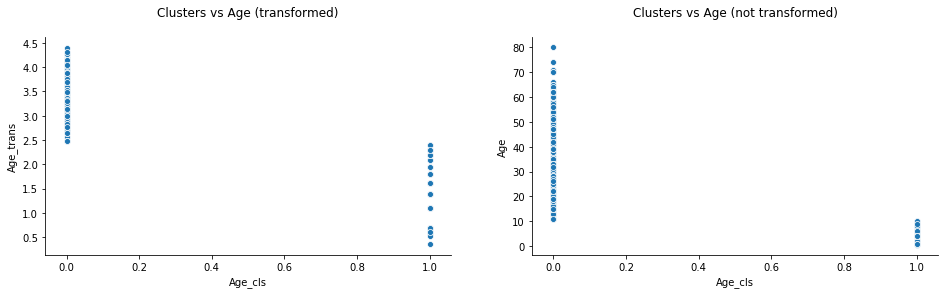

In [531]:
fig = plt.figure()
fig.set_size_inches(16,4)

fig.add_subplot(1,2,1)
ax = sns.scatterplot(x='Age_cls', y='Age_trans', data=df_age)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.07])
a=ax.set_title('Clusters vs Age (transformed)')

fig.add_subplot(1,2,2)
ax = sns.scatterplot(x='Age_cls', y='Age', data=df_age)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.07])
a=ax.set_title('Clusters vs Age (not transformed)')

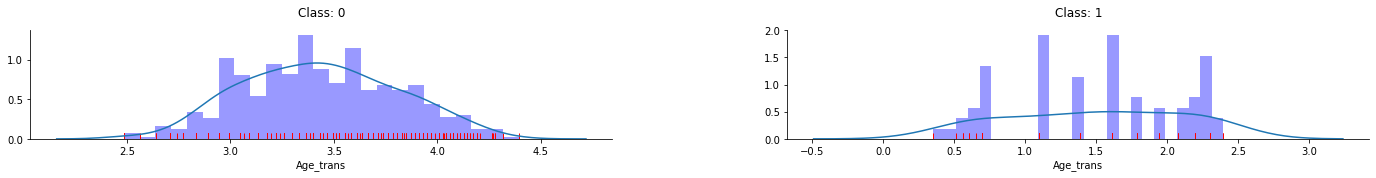

In [532]:
grd = sorted(df_age['Age_cls'].unique())
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 2
plt_w = 12


fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.8)

for idx, c in enumerate(grd):
    fig.add_subplot(gs[idx])
    df = df_age.loc[df_age['Age_cls']==c, 'Age_trans']
    ax = sns.distplot(df,
                 bins=25, kde=True, norm_hist=True, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Class: {0}'.format(c))

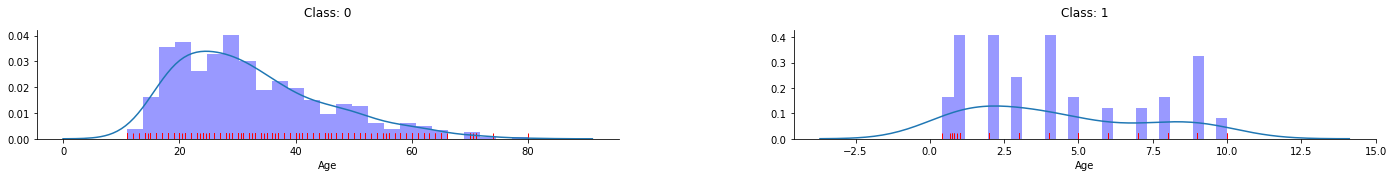

In [533]:
grd = sorted(df_age['Age_cls'].unique())
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 2
plt_w = 12


fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.8)

for idx, c in enumerate(grd):
    fig.add_subplot(gs[idx])
    df = df_age.loc[df_age['Age_cls']==c, 'Age']
    ax = sns.distplot(df,
                 bins=25, kde=True, norm_hist=True, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Class: {0}'.format(c))

In [474]:
# #Transform 'Age'
# df_age = data_train['Age'].dropna()

# age_trans = df_age.apply(lambda i: np.log(i+1)).to_frame()
# age_trans.columns = ['Age_trans']
# df_age = pd.concat([df_age.to_frame(), age_trans], axis=1)

In [475]:
# #Define clustering model
# age_cls_model = mix.GaussianMixture(n_components=5, covariance_type='spherical', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, 
#                                     init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=30)
                                 
# #Predict class labels
# age_cls = pd.DataFrame(age_cls_model.fit_predict(np.array(df_age['Age_trans']).reshape(-1,1)), columns=['Age_cls'])
# age_cls = age_cls.astype(int)

In [476]:
# df_age = pd.concat([df_age.reset_index(), age_cls], axis=1).drop(columns='index')

In [534]:
# def age_transformer(data, model):
#     age_trans = np.array(data['Age'].apply(lambda i: np.log(i+1))).reshape(-1,1)
#     age_cls = pd.DataFrame(model.fit_predict(age_trans), columns=['Age'])
#     age_cls = age_cls.astype(int)
#     return pd.concat([data.drop(columns=['Age']).reset_index(), age_cls], axis=1).drop(columns='index')

In [535]:
def age_transformer(data, model):
    age_trans = np.array(data['Age'].apply(lambda i: np.log(i+1))).reshape(-1,1)
    age_cls = pd.DataFrame(model.fit_predict(age_trans), columns=['Age_cls'])
    age_cls = age_cls.astype(int)
    data = pd.concat([data.drop(columns=['Age']).reset_index(), pd.DataFrame(age_trans, columns=['Age'])], axis=1).drop(columns='index')
    return pd.concat([data.reset_index(), age_cls], axis=1).drop(columns='index')

#### Replace 'Name' with encoded titles

In [536]:
#Concatinate train & test data
data_tot = pd.concat([data_train, data_test], ignore_index=True)

In [537]:
#Encode 'Name'
def name_encoder(data):
    data_encoded = []
    for i in data['Name']:
        lname0 = i.split(',')[0].strip() #last name
        ttl = i.split(',')[1].split('.')[0].strip() #title
        lname1 = (i.split('(')[-1].split(')')[0].split()[-1].strip() if '(' in i else '').replace('\"','') #second last name
        data_encoded.append([lname0, lname1, ttl])
    data_encoded = pd.DataFrame(data_encoded, columns=['lname0', 'lname1', 'ttl'], index=data.index)
    return pd.concat([data.reset_index(), data_encoded], axis=1).drop(columns=['index'])

In [538]:
data_tot = name_encoder(data_tot)
data_tot.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Thayer,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Peel,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,,Mr


In [539]:
#Find unique titles and their counts
ttl = data_tot['ttl'].unique()
ttl = pd.DataFrame([[i, len(data_tot.loc[data_tot['ttl']==i])] for i in ttl], columns=['ttl', 'ttl_n'])
ttl.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
ttl,Mr,Mrs,Miss,Master,Don,Rev,Dr,Mme,Ms,Major,Lady,Sir,Mlle,Col,Capt,the Countess,Jonkheer,Dona
ttl_n,757,197,260,61,1,8,8,1,2,2,1,1,2,4,1,1,1,1


In [540]:
#Explore samples with 'Dr' title
data_tot.loc[data_tot['ttl']=='Dr']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
245,246,0.0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q,Minahan,,Dr
317,318,0.0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S,Moraweck,,Dr
398,399,0.0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,Pain,,Dr
632,633,1.0,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,13214,30.5000,B50,C,Stahelin-Maeglin,,Dr
660,661,1.0,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S,Frauenthal,,Dr
766,767,0.0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C,Brewe,,Dr
796,797,1.0,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,Leader,Farnham,Dr
1184,1185,NaN,1,"Dodge, Dr. Washington",male,53.0,1,1,33638,81.8583,A34,S,Dodge,,Dr


_**There is only one woman with title 'Dr'._

The function below will replace each person's name with encoded title. Instead of using all unique titles, I will teke only these: 'Mr', 'Mrs', 'Miss' and 'Master'.

In [541]:
def title_encoder(data):
    mask = {'Don':'Mr',
            'Sir':'Mr',
            'Jonkheer':'Mr',
            'Mme':'Mrs',
            'Lady':'Mrs',
            'the Countess':'Mrs',
            'Dona':'Mrs',
            'Mlle':'Miss',
            'Ms':'Miss',
            'Major':'Mr',
            'Col':'Mr',
            'Capt':'Mr',
            'Rev':'Mr',
            'Dr':'Mr'}
    
    df = data['ttl'].apply(lambda i: mask[i] if i in mask else i)
    data = pd.concat([data.drop(columns=['ttl']), df], axis=1)
    if 797 in data['PassengerId'].values:
        data.loc[data_tot['PassengerId']==797, 'ttl'] = 'Mrs'
    mask = {'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4}
    df = data['ttl'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['ttl']), df], axis=1)

In [542]:
data_tot = title_encoder(data_tot)

#### Explore missing values for 'Embarked'

In [543]:
data_tot.loc[data_tot['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Icard,,3
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Stone,Evelyn,2


Display samples with similar ticket number

In [544]:
df = data_tot.query('Ticket.str.contains("1135")')
df.sort_values(by='Ticket')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
782,783,0.0,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.0000,D6,S,Long,,1
377,378,0.0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C,Widener,,1
965,966,NaN,1,"Geiger, Miss. Amalie",female,35.0,0,0,113503,211.5000,C130,C,Geiger,,3
966,967,NaN,1,"Keeping, Mr. Edwin",male,32.5,0,0,113503,211.5000,C132,C,Keeping,,1
1109,1110,NaN,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.0,1,1,113503,211.5000,C80,C,Widener,Elkins,2
1298,1299,NaN,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5000,C80,C,Widener,,1
166,167,1.0,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S,Chibnall,Bowerman,2
356,357,1.0,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0000,E33,S,Bowerman,,3
54,55,0.0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C,Ostby,,1
917,918,NaN,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C,Ostby,,3


All people with similar ticket numbers are embarked in 'C' or 'S'. So i will simply assign the most frequent class for both missed values.

In [545]:
nc = len(df.loc[df['Embarked']=='C'])
ns = len(df.loc[df['Embarked']=='S'])
n = len(df.index)

print('C: %d' % nc)
print('S: %d' % ns)
print('All: %d' % n)

C: 7
S: 5
All: 14


The function below will be used to encode 'Embarked' variable

In [546]:
#Encoding 'Embarked'
def embarked_encoder(data):
    if len(data.loc[data['Embarked'].isnull()].index)>0:
        data = data.fillna(value={'Embarked':'C'})
    mask = {'C':1, 'S':2, 'Q':3}
    df = data['Embarked'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['Embarked']), df], axis=1)

In [547]:
data_tot = embarked_encoder(data_tot)

### Grouping by ticket ID

While exploring the dataset, I found that many passengers have identical ticket numbers as well as identical fare value.

In this section I will do two things:
1. Group all passengers by ticked ID and add a column of the gropus IDs.
2. For all people with matching tickets, I will recalculate ticket fare for every i-th person in a group g as: fare(i, g) = fare(g) / n, where n is a number of people in group g.
3. Transform fare into categorical variable.

In [548]:
# Clean text function
def clean_text(text):
    text = ''.join([c for c in text if c not in string.punctuation]).strip()
    text = ''.join(text.split())
    return text

In [549]:
# This function will clean ticket ID from all punctuation and spaces
def ticket_encoder(data):
    df = data['Ticket'].apply(lambda i: clean_text(i)).to_frame()
    data = pd.concat([data.drop(columns=['Ticket']).reset_index(), df], axis=1)
    return data.drop(columns=['index'])

In [550]:
data_tot = ticket_encoder(data_tot)

Numbers of unique and non-unique tickets:

In [551]:
print('Unique tickets: %d' % len(data_tot['Ticket'].unique()))
print('Non-unique tickets: %d' % (len(data_tot.index) - len(data_tot['Ticket'].unique())))

Unique tickets: 929
Non-unique tickets: 380


I want to define the following groups:
1. No family (SibSp==0 & Parch==0), unique tickets
2. No family (SibSp==0 & Parch==0), non-unique tickets
3. Has family, no children (SibSp >0 & Parch==0), unique tickets
4. Has family, no children (SibSp >0 & Parch==0), non-unique tickets
5. Has family, has children (Parch >0), unique tickets
6. Has family, has children (Parch >0), non-unique tickets

In [552]:
families0 = data_tot.loc[(data_tot['SibSp']>0) & (data_tot['Parch']==0)]
families1 = data_tot.loc[data_tot['Parch']>0]
singles = data_tot.loc[(data_tot['SibSp']==0) & (data_tot['Parch']==0)]

In [553]:
# This function is used to return sub-groups by unique and non-unique tickets from a group by SibSP and Parch
def grps_by_size(grp):
    #group size > 1
    grp1 = None
    #group size == 1
    grp0 = None
    for g in grp.groups:
        grp_ = grp.get_group(g)
        if len(grp.get_group(g).index)>1:
            if grp1 is None:
                grp1 = grp_
            else:
                grp1 = pd.concat([grp1, grp_])
        else:
            if grp0 is None:
                grp0 = grp_
            else:
                grp0 = pd.concat([grp0, grp_])
    return (grp0, grp1)

In [554]:
#singles
sig_grp = singles.groupby('Ticket')
#families NO children
fam0_grp = families0.groupby('Ticket')
#families w/children
fam1_grp = families1.groupby('Ticket')

#no family, unique ticket
sig0 = grps_by_size(sig_grp)[0]
#no family, matching tickets
sig1 = grps_by_size(sig_grp)[1]
#has family, no children, unique ticket
fam0 = grps_by_size(fam0_grp)[0]
#has family, no children, matching ticket
fam1 = grps_by_size(fam0_grp)[1]
#has family, has children, unique ticket
famch0 = grps_by_size(fam1_grp)[0]
#has family, has children, matching ticket
famch1 = grps_by_size(fam1_grp)[1]

print('Singles-----------------------')
print('Matching tickets groups: %d' % len(sig1.index))
print('Unique tickets groups: %d' % len(sig0.index))
print('------------------------------')

print('Families-----------------------')
print('Matching tickets groups: %d' % len(fam1.index))
print('Unique tickets groups: %d' % len(fam0.index))
print('------------------------------')

print('Families W/children-----------------------')
print('Matching tickets groups: %d' % len(famch1.index))
print('Unique tickets groups: %d' % len(famch0.index))
print('------------------------------')

Singles-----------------------
Matching tickets groups: 108
Unique tickets groups: 682
------------------------------
Families-----------------------
Matching tickets groups: 174
Unique tickets groups: 38
------------------------------
Families W/children-----------------------
Matching tickets groups: 288
Unique tickets groups: 19
------------------------------


In [555]:
# Family groups
fam_grps = [sig0, sig1, fam0, fam1, famch0, famch1]

In [556]:
# Encode family groups
def familie_groups_encoder(data, fam_grps):
    data['fgrp'] = 0
    for idx, grp in enumerate(fam_grps):
        for pid in grp['PassengerId']:
            data.loc[data['PassengerId']==pid, 'fgrp'] = idx + 1
    return data

In [557]:
# Recalculate ticket fare in the family groups and fill missing values with a mean for corresponding passenger class.
def fare_encoder(data, encode_grps):
    for grp in encode_grps:
        fare = grp['Fare'].values[0] / len(grp.index)
        grp['Fare'] = fare
        for pid in grp['PassengerId']:
            if pid in data['PassengerId']:
                data.loc[data['PassengerId']==pid, 'Fare'] = fare
    if len(data.loc[data['Fare'].isnull()])>0:
        for pid in data.loc[data['Fare'].isnull(), 'PassengerId']:
            c = data.loc[data['PassengerId']==pid, 'Pclass'].values[0]
            data.loc[data['PassengerId']==pid, 'Fare'] = np.mean(data.loc[data['Pclass']==c, 'Fare'])
    return data

In [558]:
# Encode fare
def fare_transformer(data):
    kbd = prepc.KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
    c = pd.DataFrame(kbd.fit_transform(np.array(data['Fare']).reshape(-1,1)), columns=['Fare'])
    c = c.astype(int)
    return pd.concat([data.drop(columns=['Fare']).reset_index(), c], axis=1).drop(columns='index')

In [559]:
data_tot = familie_groups_encoder(data_tot, fam_grps)
data_tot = fare_encoder(data_tot, [sig1, fam1, famch1])
data_tot = fare_transformer(data_tot)

Functions for sex encoding and to add a family size variable:

In [560]:
# Encode 'Sex'
def sex_encoder(data):
    mask = {'male':1, 'female':2}
    df = data['Sex'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['Sex']), df], axis=1)

In [561]:
# Add 'Familie size'
def fam_size(data):
    data['famsize'] = data['SibSp'] + data['Parch'] + 1
    return data

In [562]:
data_tot = sex_encoder(data_tot)
data_tot = fam_size(data_tot)

### Predict missing missing values for age

In [563]:
data = data_tot[data_tot['Age'].notna()]
data = data[['Age', 'Fare', 'Pclass', 'Sex', 'ttl', 'fgrp', 'famsize', 'Embarked']]

In [564]:
data = age_transformer(data, age_cls_model)

Plot correlation matrix:

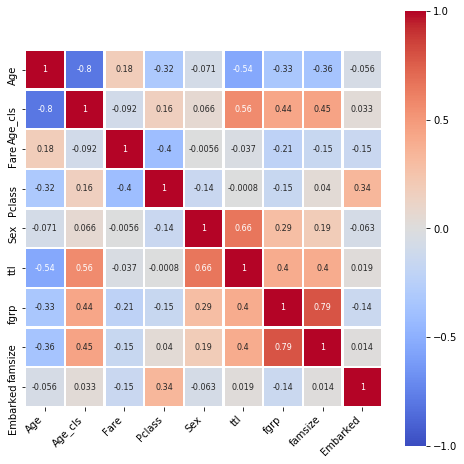

In [565]:
data = data[['Age', 'Age_cls', 'Fare', 'Pclass', 'Sex', 'ttl', 'fgrp', 'famsize', 'Embarked']]
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

In [566]:
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit, return_train_score=True,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        df = cv_res.loc[cv_res['rank_test_%s' % i] == 1].head(1)
        cv_res_sel.append(df[['mean_train_%s' % i, 'std_train_%s' % i, 'mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

In [567]:
def cv_rep(model, X, y, cv, scoring):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, n_jobs=-1)
    cv_res = [[np.mean(cv_res['train_%s' % i]), np.std(cv_res['train_%s' % i]), np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

In [568]:
def train_best_model(model, param_ranges, X_train, y_train, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

In [569]:
def train_best_model_cal(model, param_ranges, X_train, y_train, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

In [570]:
def dropcol_imp_r2_metric(model, X_valid, y_valid, sample_weights):
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_valid)
    return metrics.r2_score(y_valid, y_pred, sample_weight=sample_weights)

In [571]:
def dropcol_imp_roc_auc_metric(model, X_valid, y_valid, sample_weights):
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_valid)
    return metrics.roc_auc_score(y_valid, y_pred, sample_weight=sample_weights)

In [572]:
def dropcol_imp_accuracy_metric(model, X_valid, y_valid, sample_weights):
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_valid)
    return metrics.accuracy_score(y_valid, y_pred, sample_weight=sample_weights)

In [573]:
    def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None):
        """Plots confusion matrix
        Parameters:
        ax =  matplotlib axes
        normalyze = normalization over truth (number_predicted / total_count_of_this_class)
        """
        model.fit(X,y)
        conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                                  labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
        classes = y.unique()
        classes.sort()
        n_classes = [len(y[y == c]) for c in classes]
        if normalize == True:
            n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
            norm_matrix = conf_matrix / np.array(n_classes)
            ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
            labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                                   ns_matrix[i, j]) for j, v in
                                enumerate(norm_matrix[i])]
                               for i, v in enumerate(norm_matrix)])

            sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
        else:
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        
        ax.set_ylabel('True Labels')
        ax.set_xlabel('Predicted Labels')
        if title is None:
            title = model.__class__.__name__
        ax.set_title(title)
        ttl = ax.title
        ttl.set_position([.5, 1.07])

        # fix for mpl bug that cuts off top/bottom of seaborn viz
        b, t = ax.get_ylim()  # discover the values for bottom and top
        b += 0.5  # Add 0.5 to the bottom
        t -= 0.5  # Subtract 0.5 from the top
        ax.set_ylim(b, t)  # update the ylim(bottom, top) values

In [574]:
def feature_importance(model, X_train, y_train, X_test, y_test, metric, label=None):
    feature_importance = dropcol_importances(model, X_train, y_train, X_valid=X_test, y_valid=y_test, metric=metric)
    if label is None:
        label = model.__class__.__name__
    feature_importance.columns = [label]
    return feature_importance

In [575]:
def roc_auc_score_ovr(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None,
                                 multi_class='ovr', labels=None)

def roc_auc_score_ovo(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None,
                                 multi_class='ovo', labels=None)

In [657]:
# train test split
X = data.drop(columns=['Age', 'Age_cls'])
y = data['Age_cls']

In [658]:
X.columns

Index(['Fare', 'Pclass', 'Sex', 'ttl', 'fgrp', 'famsize', 'Embarked'], dtype='object')

In [659]:
# #common random_state
# random_state=30
# #cross validation strategy
# cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
# # cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)
# #cross validation metrics
# scoring = {'balanced_accuracy': 'balanced_accuracy',
#            'roc_auc_ovr':  metrics.make_scorer(roc_auc_score_ovr, needs_proba=True),
#            'roc_auc_ovo':  metrics.make_scorer(roc_auc_score_ovo, needs_proba=True),
#            'precision_macro': 'precision_macro'}
# refit = 'roc_auc_ovr'

In [660]:
#common random_state
random_state=30
#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
# cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)
#cross validation metrics
scoring = {'balanced_accuracy': 'balanced_accuracy',
           'roc_auc':  'roc_auc',
           'precision_macro': 'precision_macro'}
refit = 'balanced_accuracy'

In [661]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [662]:
base_scores = {}

In [663]:
n = len(y)
class_priors = {}
class_weights = {}
for i in y.unique():
    class_priors[i] = len(y.loc[y==i]) / n
    class_weights[i] = 1- class_priors[i]

In [664]:
class_weights

{0: 0.0822179732313576, 1: 0.9177820267686424}

In [665]:
gpc = gaup.GaussianProcessClassifier(kernel=None, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, random_state=random_state)
# param_ranges = {'base_estimator__max_iter_predict': np.arange(1, 50, 10)}
# gpc, scores = train_best_model_cal(gpc, param_ranges, X, y, scoring, cv, refit=refit)
param_ranges = {'max_iter_predict': np.arange(1, 50, 10)}
gpc, scores = train_best_model(gpc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['gpc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.954843  0.993741         0.922087
std_train            0.022678  0.001966         0.020783
mean_test            0.925522  0.990221         0.923660
std_test             0.036012  0.005851         0.035929
{'max_iter_predict': 11}


In [666]:
lda = disan.LinearDiscriminantAnalysis(solver='svd', shrinkage=None)
param_ranges = {'n_components': np.arange(1,10)}
lda, scores = train_best_model(lda, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['lda'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.760950  0.990440         0.900834
std_train            0.025160  0.002414         0.026101
mean_test            0.777502  0.990740         0.903179
std_test             0.045590  0.002958         0.037458
{'n_components': 1}


In [667]:
qda = disan.QuadraticDiscriminantAnalysis(priors=[class_priors[i] for i in class_priors])
param_ranges = {'reg_param': np.linspace(0.01,1,12)}
qda, scores = train_best_model(qda, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['qda'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.969182  0.988323         0.852849
std_train            0.005094  0.002892         0.018939
mean_test            0.969260  0.986588         0.849296
std_test             0.011537  0.007430         0.030970
{'reg_param': 0.55}


c:\00_data\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [668]:
abc = ens.AdaBoostClassifier(algorithm='SAMME.R', random_state=random_state)
param_ranges = {'n_estimators': np.arange(5, 100, 20), 'learning_rate': np.linspace(0.001, 0.3, 20)}
abc, scores = train_best_model(abc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['abc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.960361  0.994013         0.904895
std_train            0.010838  0.001908         0.024177
mean_test            0.951792  0.990775         0.916762
std_test             0.031936  0.005089         0.042429
{'learning_rate': 0.06394736842105263, 'n_estimators': 85}


In [669]:
gbc = ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
                                     min_samples_split=2, min_samples_leaf=1,
                                     init=None, random_state=random_state, 
                                     max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='deprecated', 
                                     validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

param_ranges = {'min_weight_fraction_leaf': np.linspace(0.01, 0.2, 10), 'min_impurity_decrease': np.linspace(0.01, 0.2, 15)}
gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'learning_rate': np.linspace(0.01, 0.2, 10), 'n_estimators': np.arange(5, 100, 20)}
gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'max_depth': np.arange(3, 6)}
gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)


base_scores['gbc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.965696  0.992580         0.914323
std_train            0.014125  0.002013         0.018012
mean_test            0.957446  0.991564         0.905430
std_test             0.024508  0.003705         0.017923
{'min_impurity_decrease': 0.037142857142857144, 'min_weight_fraction_leaf': 0.11555555555555555}
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.968933  0.990970         0.908204
std_train            0.010513  0.002277         0.020958
mean_test            0.959619  0.989280         0.897544
std_test             0.026372  0.005951         0.022186
{'learning_rate': 0.03111111111111111, 'n_estimators': 85}
            balanced_accuracy   roc_auc  precision_macro
mean_train           0.968933  0.990336         0.905758
std_train            0.010513  0.002354         0.020847
mean_test            0.959619  0.988540         0.896533
std_test             0.026372  0.006556       

In [670]:
# fig = plt.figure()
# fig.set_size_inches(6,6)
# plot_confusion_matrix(gbc, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='gbc')

In [671]:
etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                               min_samples_split=2,
                               min_samples_leaf=1)
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['etc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.974339  0.996022         0.922915
std_train            0.011436  0.001228         0.023322
mean_test            0.944138  0.990913         0.925650
std_test             0.033209  0.004558         0.035164
{'max_depth': 9, 'n_estimators': 5}


In [672]:
# rfecv = feature_selection.RFECV(estimator=etc, step=1, min_features_to_select=1, cv=cv, scoring='accuracy', n_jobs=-1)
# rfecv.fit(X, y)
# print("Optimal number of features : %d" % rfecv.n_features_)

# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

In [673]:
rfc = ens.RandomForestClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                               min_samples_split=2,
                               min_samples_leaf=1)
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(5, 10)}
rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['rfc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.972508  0.995186         0.923365
std_train            0.011025  0.001336         0.012785
mean_test            0.940830  0.990913         0.901554
std_test             0.028491  0.005310         0.029418
{'max_depth': 5, 'n_estimators': 85}


In [674]:
lr = lm.LogisticRegression(class_weight=class_weights, random_state=random_state, n_jobs=-1)
param_ranges = {'C': np.linspace(0.01, 5, 20)}
lr, scores = train_best_model(lr, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['lr'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.971878  0.990915         0.838289
std_train            0.006193  0.002220         0.018902
mean_test            0.970547  0.991031         0.833568
std_test             0.011083  0.003940         0.025054
{'C': 4.737368421052632}


In [675]:
pac = lm.PassiveAggressiveClassifier(class_weight=class_weights, random_state=random_state, n_jobs=-1)
param_ranges = {'base_estimator__C': np.linspace(0.01, 1, 20)}
pac, scores = train_best_model_cal(pac, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['pac'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.795135  0.985125         0.900148
std_train            0.029696  0.003183         0.024250
mean_test            0.808464  0.985204         0.911096
std_test             0.054229  0.006051         0.043699
{'base_estimator__C': 0.01}


In [676]:
rc = lm.RidgeClassifier(class_weight=class_weights, random_state=random_state, solver='auto')
param_ranges = {'base_estimator__alpha': np.linspace(0.01, 40, 20)}
rc, scores = train_best_model_cal(rc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['rc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.904495  0.990089         0.909602
std_train            0.010408  0.002747         0.019813
mean_test            0.912118  0.989827         0.928587
std_test             0.031802  0.003683         0.031879
{'base_estimator__alpha': 6.32421052631579}


In [677]:
svc = svm.SVC(kernel='rbf', gamma='scale', shrinking=True, probability=True, class_weight=class_weights)
param_ranges = {'C': np.linspace(0.01, 10, 20)}
svc, scores = train_best_model(svc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['svc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.973704  0.992834         0.847687
std_train            0.005732  0.002021         0.016662
mean_test            0.974201  0.992637         0.833247
std_test             0.007874  0.004313         0.024511
{'C': 10.0}


In [678]:
lsvc = svm.LinearSVC(penalty='l2', loss='squared_hinge', class_weight=class_weights, max_iter=1500, tol=0.05)
param_ranges = {'base_estimator__C': np.linspace(0.005, 1, 20)}
lsvc, scores = train_best_model_cal(lsvc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['lsvc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.806321  0.988343         0.905437
std_train            0.025610  0.003006         0.024692
mean_test            0.820464  0.988429         0.911431
std_test             0.045951  0.004106         0.037129
{'base_estimator__C': 0.21447368421052632}


In [679]:
nusvc = svm.NuSVC(kernel='rbf', gamma='scale', shrinking=True, probability=True, class_weight=class_weights)
param_ranges = {'nu': np.linspace(0.1,1,10)}
nusvc, scores = train_best_model(nusvc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['nusvc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.934124  0.990691         0.928530
std_train            0.027110  0.003441         0.019268
mean_test            0.922907  0.989730         0.915057
std_test             0.038924  0.009186         0.025281
{'nu': 0.1}


In [680]:
pd.Series(base_scores, name='test').sort_values(ascending=False)

svc      0.974201
lr       0.970547
qda      0.969260
gbc      0.959619
abc      0.951792
etc      0.944138
rfc      0.940830
gpc      0.925522
nusvc    0.922907
rc       0.912118
lsvc     0.820464
pac      0.808464
lda      0.777502
Name: test, dtype: float64

In [681]:
base_models_age_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rfc':rfc,'lr':lr,'pac':pac,'rc':rc,'svc':svc,'lsvc':lsvc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc}

In [682]:
base_models_age = [(k,base_models_age_dic[k]) for k in base_models_age_dic.keys()]

c:\00_data\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


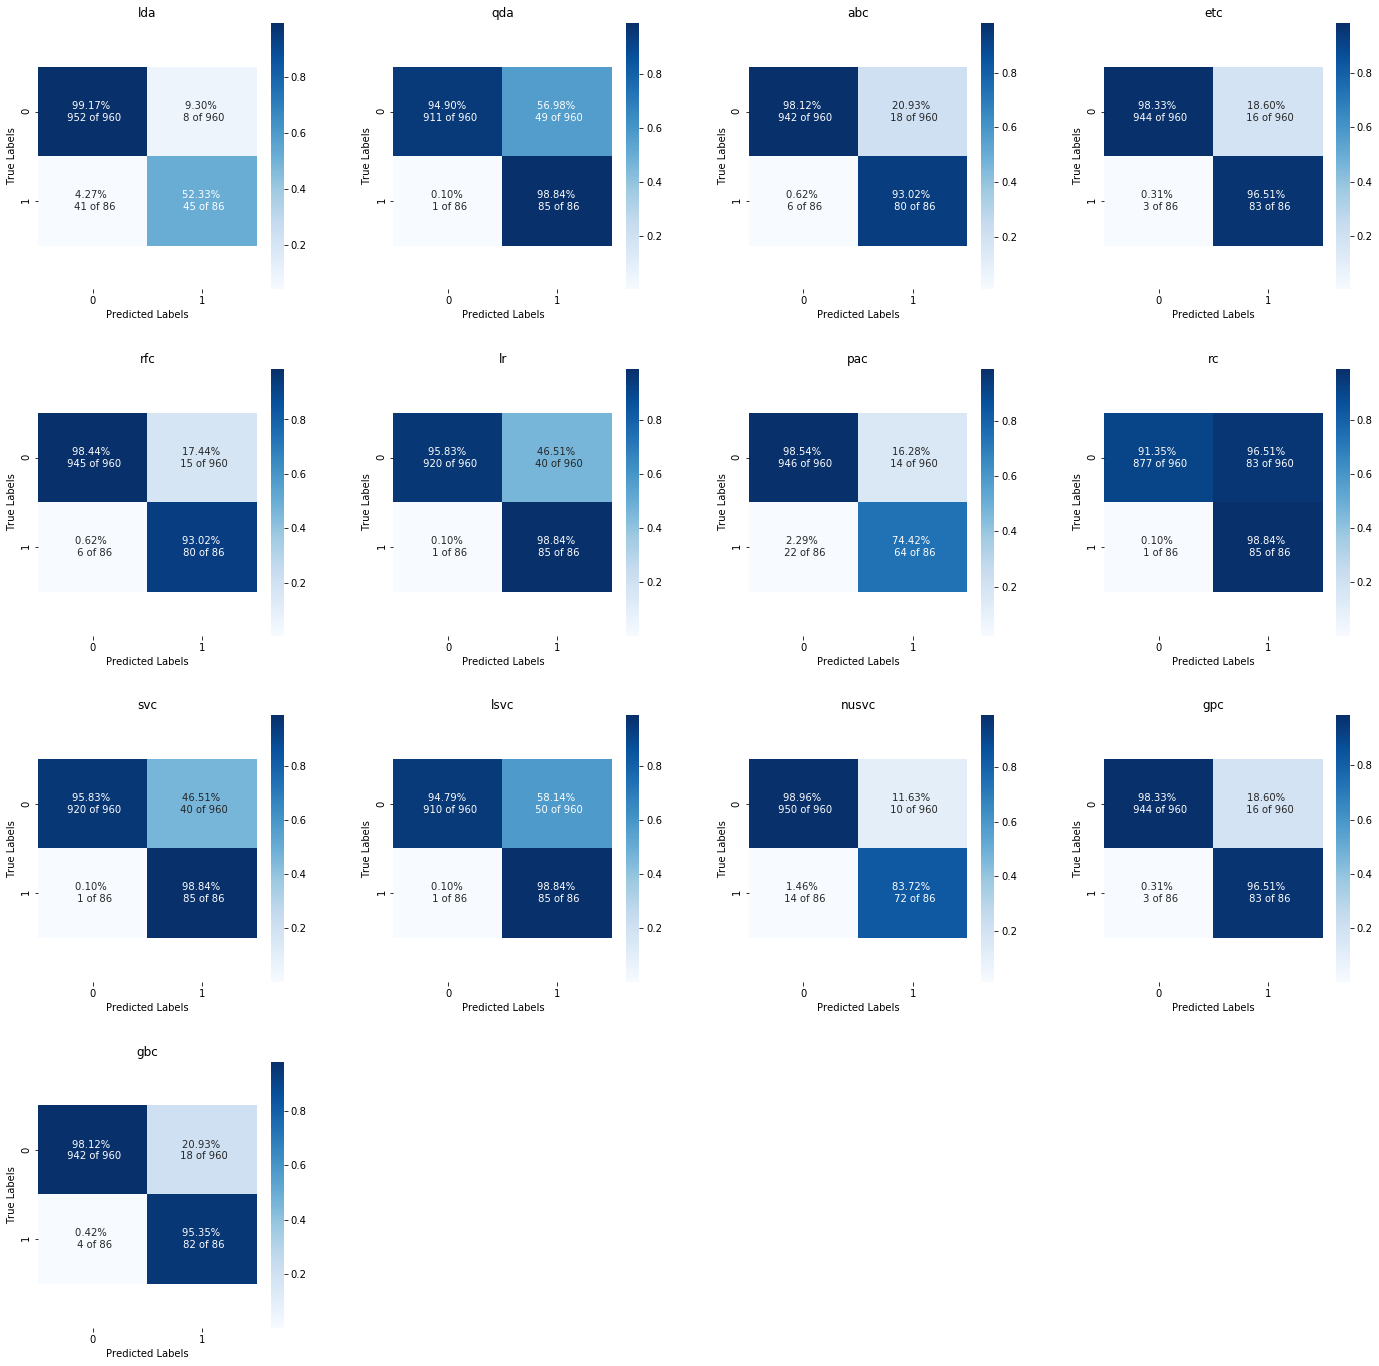

In [683]:
grd_n = len(base_models_age)
grd_cols_n = 4
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(6 * grd_cols_n, 6 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(base_models_age):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

In [611]:
# X_train, X_test, y_train, y_test =model_selection.train_test_split(X, y, test_size=0.3, random_state=30)

# feature_importance_base = None
# for k in base_models_age.keys():
#     if feature_importance_base is None:
#         feature_importance_base = feature_importance(base_models_age[k], X_train, y_train, X_test, y_test, metric=dropcol_imp_accuracy_metric, label=k)
#     else:
#         feature_importance_base = feature_importance_base.merge(feature_importance(base_models_age[k], X_train, y_train, X_test, y_test, metric=dropcol_imp_accuracy_metric, label=k),
#                                                                     left_index=True, right_index=True)

In [612]:
# feature_importance_base.T.apply(np.mean).sort_values(ascending=False)

In [613]:
# train test split
X = data.drop(columns=['Age'])
y = data['Age']

In [525]:
#Train/Test split
# X_train, X_test, y_train, y_test =model_selection.train_test_split(X, y, test_size=0.1, shuffle=True, random_state=30)
#common random_state
random_state=30
#cross validation strategy
cv_folds = 5
# n_repeats = 10
cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.3, train_size=0.6, random_state=random_state)
# cv = model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_state)
#cross validation metrics
scoring = {'explained_variance':  'explained_variance',
           'r2': 'r2'}
refit='r2'

In [527]:
etr = ens.ExtraTreesRegressor(random_state=random_state, n_jobs=-1)
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
etr, scores = train_best_model(etr, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.953432  0.946556
std_train             0.003741  0.004301
mean_test             0.927994  0.927598
std_test              0.012214  0.012974
{'max_depth': 6, 'n_estimators': 85}


In [ ]:

#             explained_variance        r2
# mean_train            0.853143  0.853143
# std_train             0.010327  0.010327
# mean_test             0.828022  0.825839
# std_test              0.018105  0.019050
# {'max_depth': 4, 'n_estimators': 85}

In [401]:
rfr = ens.RandomForestRegressor(min_samples_split = 2, min_samples_leaf = 1, random_state=random_state, n_jobs=-1)
param_ranges = {'n_estimators': np.arange(5, 100, 20),
                'max_depth': np.arange(3, 10)}
rfr, scores = train_best_model(rfr, param_ranges, X, y, scoring, cv, refit='r2')
# base_scores['rfr'] = scores

            explained_variance        r2
mean_train            0.744423  0.744420
std_train             0.010880  0.010880
mean_test             0.699706  0.697998
std_test              0.063161  0.063684
{'max_depth': 4, 'n_estimators': 85}


### Preprocess train set for classification

**Pipeline:**
1. Encode name
2. Encode title
3. Encode embarked
4. Encode familie groups
5. Encode fare
6. Encode sex
7. Add familie size
8. Encode age

In [268]:
def fare_transformer(data):
    c = data['Fare'].apply(lambda i: np.log(i+1)).to_frame()
    kbd = prepc.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
    c = pd.DataFrame(kbd.fit_transform(np.array(c).reshape(-1,1)), columns=['Fare'])
    c = c.astype(int)
    return pd.concat([data.drop(columns=['Fare']).reset_index(), c], axis=1).drop(columns='index')

In [269]:
def fare_transformer(data):
    c = data['Fare'].apply(lambda i: np.log(i+1)).to_frame()
    data = data.drop(columns='Fare')
    data = pd.concat([data, c], axis=1)
    kbd = prepc.KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='kmeans')
    c = pd.DataFrame(kbd.fit_transform(np.array(data['Fare']).reshape(-1,1)), columns=['Fare'])
    c = c.astype(int)
    return pd.concat([data.drop(columns=['Fare']).reset_index(), c], axis=1).drop(columns='index')

In [553]:
#Age encoder
def age_encoder(data, final_model_age):
    data = fare_transformer(data)
    data_na = data[data['Age'].isnull()]
    data_notna = data[data['Age'].notna()]
    #transform non-null age values
    data_notna = age_transformer(data_notna)
    #predict missing values
    y = pd.Series(final_model_age.predict(data_na[['Fare', 'Pclass', 'Sex', 'ttl', 'fgrp', 'famsize', 'Embarked']]), name='Age').to_frame()
    data_na = pd.concat([data_na.reset_index().drop(columns=['Age', 'index']), y], axis=1)
    data = pd.concat([data_na, data_notna])
    kbd = prepc.KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='kmeans')
    c = pd.DataFrame(kbd.fit_transform(np.array(data['Age']).reshape(-1,1)), columns=['Age'])
    c = c.astype(int)
    return pd.concat([data.drop(columns=['Age']).reset_index(), c], axis=1).drop(columns='index')

In [554]:
data_train1 = name_encoder(data_train)
data_train1 = title_encoder(data_train1)
data_train1 = embarked_encoder(data_train1)
data_train1 = familie_groups_encoder(data_train1, fam_grps)
data_train1 = fare_encoder(data_train1, [sig1, fam1, famch1])
data_train1 = sex_encoder(data_train1)
data_train1 = fam_size(data_train1)
data_train1 = age_encoder(data_train1, model_age)

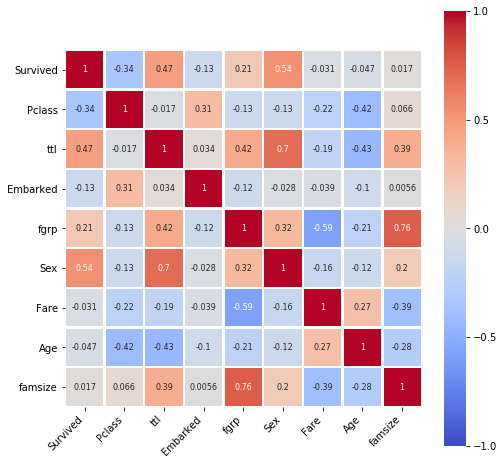

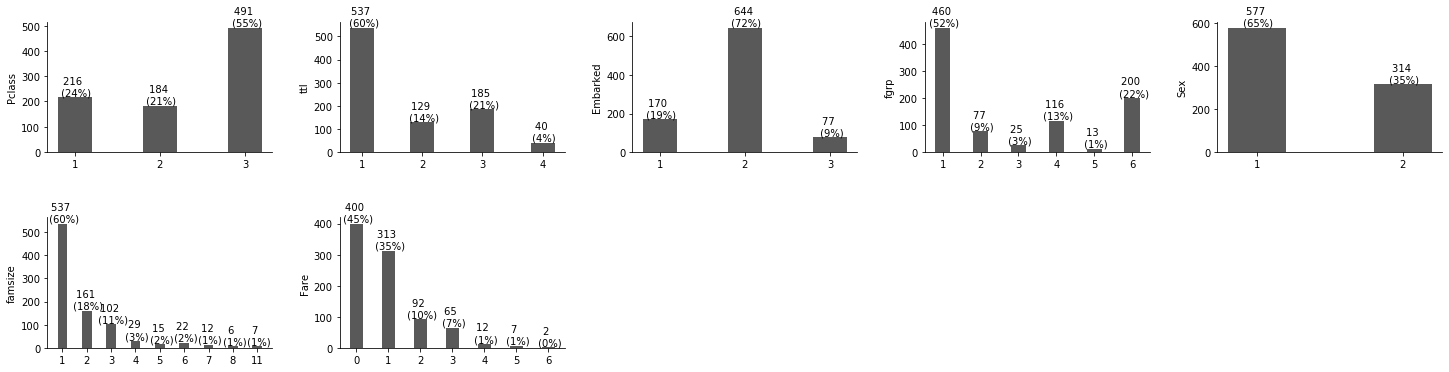

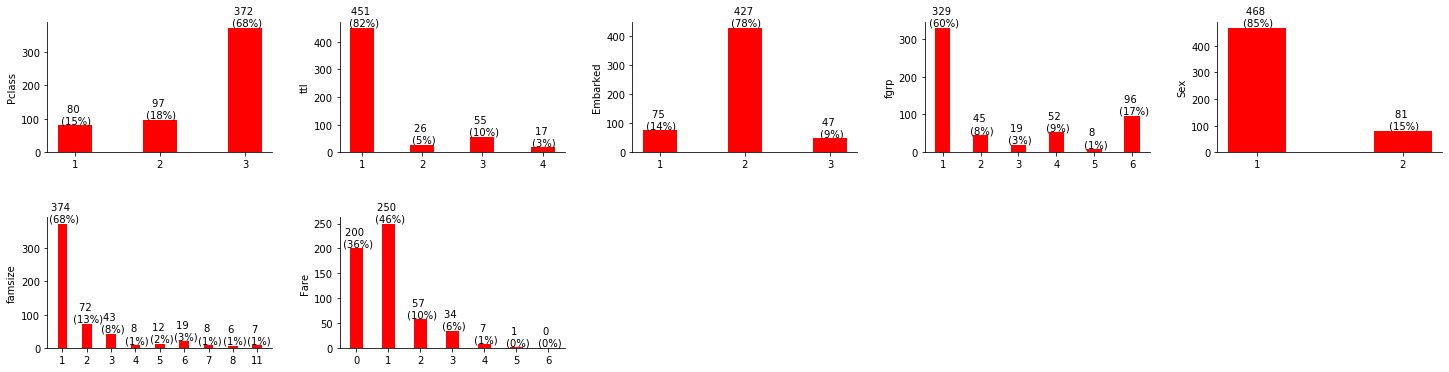

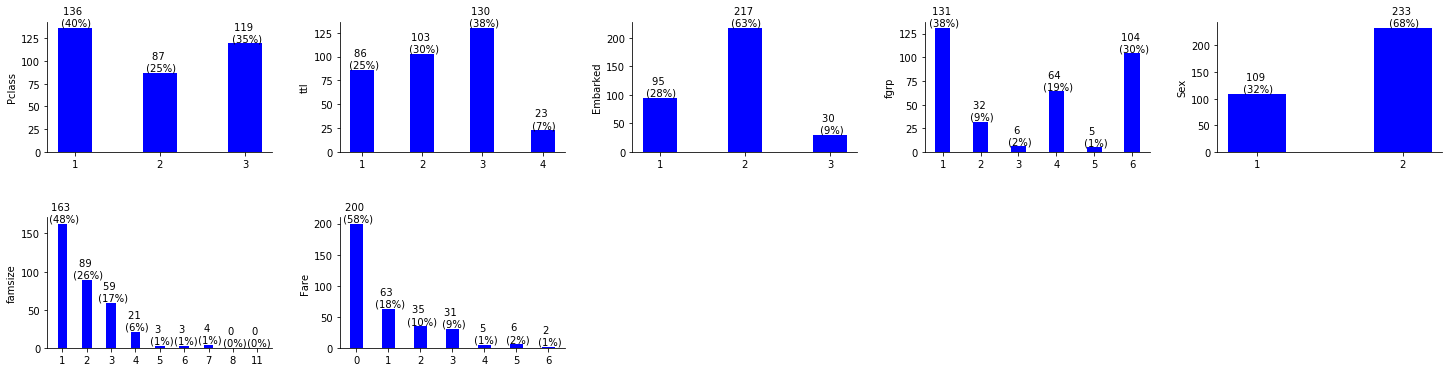

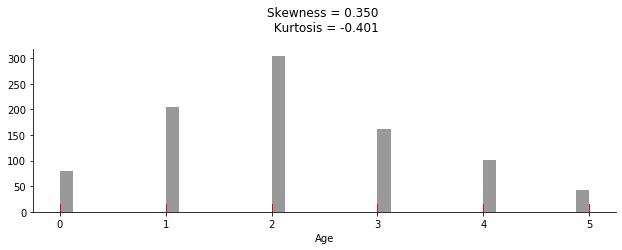

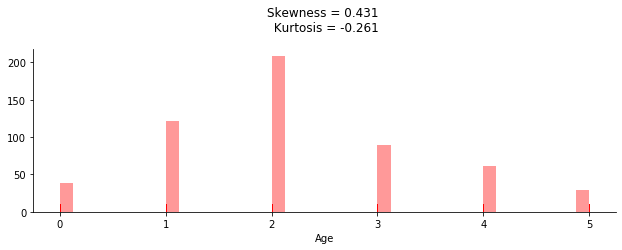

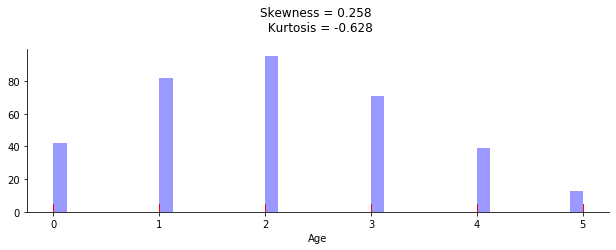

In [555]:
data = data_train1[['Survived','Pclass','ttl','Embarked','fgrp','Sex','Fare', 'Age', 'famsize']]
data_cat = data[['Pclass','ttl','Embarked','fgrp','Sex','famsize', 'Fare']]
data_num = data[['Age']]

#plot correlation matrix
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

grd = list(data_cat.columns)
grd_n = len(grd)
grd_cols_n = 5
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 5

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n = len(data.loc[data[col]==i, col].index)
        fr = n / len(data.index)
        freq.append([n])
        frc.append([fr])

    df_freq = pd.DataFrame(freq, columns=['all'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['all'], index=data_cat[col].unique()).T
    labs = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['all'], df_frc.loc['all'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs],
                           plots_labels=None,
                           plots_colors=['0.35'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (non-survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n0 = len(data.loc[(data['Survived']==0) & (data[col]==i), col].index)
        fr0 = n0 / N_surv0
        freq.append([n0])
        frc.append([fr0])

    df_freq = pd.DataFrame(freq, columns=['non_survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['non_survivals'], index=data_cat[col].unique()).T
    labs0 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['non_survivals'], df_frc.loc['non_survivals'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs0],
                           plots_labels=None,
                           plots_colors=['r'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n1 = len(data.loc[(data['Survived']==1) & (data[col]==i), col].index)
        fr1 = n1 / N_surv1
        freq.append([n1])
        frc.append([fr1])

    df_freq = pd.DataFrame(freq, columns=['survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['survivals'], index=data_cat[col].unique()).T
    labs1 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['survivals'], df_frc.loc['survivals'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs1],
                           plots_labels=None,
                           plots_colors=['b'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    

    
grd = list(data_num.columns)
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.7)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data[col].dropna()
    ax = sns.distplot(df,
                 bins=40, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "0"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (NON-SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.7)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==0, col].dropna()
    ax = sns.distplot(df,
                 bins=40, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "r"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.7)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==1, col].dropna()
    ax = sns.distplot(df,
                 bins=40, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))


In [561]:
def base_models_predictions(models, X):
    X1 = None
    for i, model in models:
        if X1 is None:
            X1 = pd.Series(model.predict(X), name=i).to_frame()
        else:
            X1 = X1.merge(pd.Series(model.predict(X), name=i).to_frame(), left_index=True, right_index=True)
    return X1

In [562]:
def base_models_predictions_proba(models, X):
    X0 = None
    X1 = None
    for i, model in models:
#         print(model.predict_proba(X))
        proba_0 = model.predict_proba(X)[:,0]
        proba_1 = model.predict_proba(X)[:,1]
#         print(proba_0)
        if X0 is None:
            X0 = pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame()
        else:
            X0 = X0.merge(pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
        
        if X1 is None:
            X1 = pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame()
        else:
            X1 = X1.merge(pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
    return (X0, X1)

In [597]:
# train test split
X = data.drop(columns=['Survived', 'famsize'])
y = data['Survived']

In [618]:
#common random_state
random_state=30
#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=8, test_size=0.3, train_size=0.6, random_state=random_state)
#cross validation metrics
scoring = {'roc_auc':  'roc_auc',
           'accuracy': 'accuracy',
           'precision_macro': 'precision_macro'}
refit = 'accuracy'

In [619]:
base_scores = {}

In [620]:
# class_weight='balanced'
class_weight={0:0.62,1:0.38}

In [621]:
gpc = gaup.GaussianProcessClassifier(kernel=None, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, random_state=random_state)
param_ranges = {'base_estimator__max_iter_predict': np.arange(1, 50, 10)}
gpc, scores = train_best_model_cal(gpc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['gpc'] = scores.loc['mean_test', refit]

             roc_auc  accuracy  precision_macro
mean_train  0.889976  0.859551         0.854936
std_train   0.009446  0.013075         0.014511
mean_test   0.845605  0.801306         0.795833
std_test    0.030563  0.022907         0.025086
{'base_estimator__max_iter_predict': 11}


In [622]:
lda = disan.LinearDiscriminantAnalysis(solver='svd', shrinkage=None)
param_ranges = {'base_estimator__n_components': np.arange(1,10)}
lda, scores = train_best_model_cal(lda, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['lda'] = scores.loc['mean_test', refit]

             roc_auc  accuracy  precision_macro
mean_train  0.861320  0.807584         0.800093
std_train   0.014631  0.012796         0.013553
mean_test   0.848621  0.782649         0.775430
std_test    0.028866  0.028032         0.030195
{'base_estimator__n_components': 1}


In [623]:
qda = disan.QuadraticDiscriminantAnalysis(priors=[class_weight[0], class_weight[1]])
param_ranges = {'base_estimator__reg_param': np.linspace(0.01,1,12)}
qda, scores = train_best_model_cal(qda, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['qda'] = scores.loc['mean_test', refit]

             roc_auc  accuracy  precision_macro
mean_train  0.856563  0.808755         0.806965
std_train   0.016089  0.011823         0.011867
mean_test   0.845363  0.796175         0.797659
std_test    0.025342  0.021672         0.024163
{'base_estimator__reg_param': 0.01}


In [625]:
abc = ens.AdaBoostClassifier(algorithm='SAMME.R', random_state=random_state)
param_ranges = {'base_estimator__n_estimators': np.arange(5, 100, 20), 'base_estimator__learning_rate': np.linspace(0.001, 0.3, 20)}
abc, scores = train_best_model_cal(abc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['abc'] = scores.loc['mean_test', refit]

             roc_auc  accuracy  precision_macro
mean_train  0.870751  0.825140         0.818454
std_train   0.012287  0.015412         0.017204
mean_test   0.855027  0.799440         0.791808
std_test    0.029310  0.026631         0.027997
{'base_estimator__learning_rate': 0.2527894736842105, 'base_estimator__n_estimators': 85}


In [626]:
gbc = ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
                                     min_samples_split=2, min_samples_leaf=1,
                                     init=None, random_state=random_state, 
                                     max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='deprecated', 
                                     validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
param_ranges = {'base_estimator__learning_rate': np.linspace(0.01, 0.2, 10), 'base_estimator__n_estimators': np.arange(5, 100, 20)}
gbc, scores = train_best_model_cal(gbc, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'base_estimator__min_weight_fraction_leaf': np.linspace(0.01, 0.2, 10), 'base_estimator__min_impurity_decrease': np.linspace(0.01, 0.2, 15)}
gbc, scores = train_best_model_cal(gbc, param_ranges, X, y, scoring, cv, refit=refit)

param_ranges = {'base_estimator__subsample': np.linspace(0.1, 1.1, 15), 'base_estimator__max_depth': np.arange(3, 6)}
gbc, scores = train_best_model_cal(gbc, param_ranges, X, y, scoring, cv, refit=refit)


base_scores['gbc'] = scores.loc['mean_test', refit]

             roc_auc  accuracy  precision_macro
mean_train  0.890075  0.859082         0.870973
std_train   0.013412  0.012199         0.011043
mean_test   0.854715  0.817164         0.825975
std_test    0.030136  0.018088         0.022098
{'base_estimator__learning_rate': 0.2, 'base_estimator__n_estimators': 45}
             roc_auc  accuracy  precision_macro
mean_train  0.882262  0.852528         0.833323
std_train   0.013001  0.010624         0.010797
mean_test   0.860599  0.814366         0.820110
std_test    0.030204  0.021496         0.021858
{'base_estimator__min_impurity_decrease': 0.01, 'base_estimator__min_weight_fraction_leaf': 0.01}
             roc_auc  accuracy  precision_macro
mean_train  0.921167  0.862360         0.863958
std_train   0.008119  0.011954         0.010159
mean_test   0.848305  0.819496         0.837726
std_test    0.030873  0.020517         0.018469
{'base_estimator__max_depth': 3, 'base_estimator__subsample': 0.8142857142857142}


In [627]:
etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                               min_samples_split=2,
                               min_samples_leaf=1)
param_ranges = {'base_estimator__n_estimators': np.arange(5, 100, 20),
                'base_estimator__max_depth': np.arange(3, 10)}
etc, scores = train_best_model_cal(etc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['etc'] = scores.loc['mean_test', refit]

             roc_auc  accuracy  precision_macro
mean_train  0.898167  0.872191         0.877951
std_train   0.011668  0.013785         0.014907
mean_test   0.860051  0.806903         0.805964
std_test    0.024447  0.029008         0.035588
{'base_estimator__max_depth': 7, 'base_estimator__n_estimators': 5}


In [628]:
rfc = ens.RandomForestClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                               min_samples_split=2,
                               min_samples_leaf=1)
param_ranges = {'base_estimator__n_estimators': np.arange(5, 100, 20),
                'base_estimator__max_depth': np.arange(5, 10)}
rfc, scores = train_best_model_cal(rfc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['rfc'] = scores.loc['mean_test', refit]

             roc_auc  accuracy  precision_macro
mean_train  0.906963  0.862828         0.865773
std_train   0.011261  0.015435         0.014218
mean_test   0.857256  0.809235         0.809000
std_test    0.025249  0.030108         0.035359
{'base_estimator__max_depth': 6, 'base_estimator__n_estimators': 85}


In [629]:
lr = lm.LogisticRegression(class_weight=class_weight, random_state=random_state, n_jobs=-1)
param_ranges = {'base_estimator__C': np.linspace(0.01, 5, 20)}
lr, scores = train_best_model_cal(lr, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['lr'] = scores.loc['mean_test', refit]

             roc_auc  accuracy  precision_macro
mean_train  0.862495  0.807818         0.801704
std_train   0.013895  0.014136         0.015309
mean_test   0.852394  0.795243         0.791330
std_test    0.029750  0.021951         0.021269
{'base_estimator__C': 0.5352631578947369}


In [630]:
pac = lm.PassiveAggressiveClassifier(class_weight=class_weight, random_state=random_state, n_jobs=-1)
param_ranges = {'base_estimator__C': np.linspace(0.01, 1, 20)}
pac, scores = train_best_model_cal(pac, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['pac'] = scores.loc['mean_test', refit]

             roc_auc  accuracy  precision_macro
mean_train  0.858266  0.799625         0.791818
std_train   0.015938  0.016645         0.018498
mean_test   0.851180  0.794776         0.789754
std_test    0.026443  0.018934         0.017902
{'base_estimator__C': 0.01}


In [631]:
rc = lm.RidgeClassifier(class_weight=class_weight, random_state=random_state, solver='auto')
param_ranges = {'base_estimator__alpha': np.linspace(0.01, 40, 20)}
rc, scores = train_best_model_cal(rc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['rc'] = scores.loc['mean_test', refit]

             roc_auc  accuracy  precision_macro
mean_train  0.859949  0.807116         0.801167
std_train   0.014854  0.015414         0.016317
mean_test   0.850688  0.795709         0.790872
std_test    0.026752  0.021251         0.019740
{'base_estimator__alpha': 6.32421052631579}


In [632]:
svc = svm.SVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weight)
param_ranges = {'base_estimator__C': np.linspace(0.01, 10, 20)}
svc, scores = train_best_model_cal(svc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['svc'] = scores.loc['mean_test', refit]

             roc_auc  accuracy  precision_macro
mean_train  0.893595  0.822331         0.852146
std_train   0.010976  0.012819         0.012753
mean_test   0.844679  0.806903         0.818640
std_test    0.028971  0.022134         0.021820
{'base_estimator__C': 1.0615789473684212}


In [633]:
lsvc = svm.LinearSVC(penalty='l2', loss='squared_hinge', class_weight=class_weight, max_iter=1500, tol=0.05)
param_ranges = {'base_estimator__C': np.linspace(0.005, 1, 20)}
lsvc, scores = train_best_model_cal(lsvc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['lsvc'] = scores.loc['mean_test', refit]

             roc_auc  accuracy  precision_macro
mean_train  0.860794  0.797051         0.791799
std_train   0.014234  0.016189         0.017651
mean_test   0.854917  0.797575         0.792262
std_test    0.027085  0.021737         0.019699
{'base_estimator__C': 0.057368421052631575}


In [634]:
nusvc = svm.NuSVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weight)
param_ranges = {'base_estimator__nu': np.linspace(0.1,1,10)}
nusvc, scores = train_best_model_cal(nusvc, param_ranges, X, y, scoring, cv, refit=refit)
base_scores['nusvc'] = scores.loc['mean_test', refit]

             roc_auc  accuracy  precision_macro
mean_train  0.897782  0.844101         0.874456
std_train   0.006301  0.009445         0.010602
mean_test   0.856204  0.809701         0.816144
std_test    0.024576  0.029083         0.034371
{'base_estimator__nu': 0.4}


In [635]:
pd.Series(base_scores, name='test').sort_values(ascending=False)

gbc      0.819496
nusvc    0.809701
rfc      0.809235
svc      0.806903
etc      0.806903
gpc      0.801306
abc      0.799440
lsvc     0.797575
qda      0.796175
rc       0.795709
lr       0.795243
pac      0.794776
lda      0.782649
Name: test, dtype: float64

In [636]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rfc':rfc,'lr':lr,'pac':pac,'rc':rc,'svc':svc,'lsvc':lsvc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc}

In [637]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

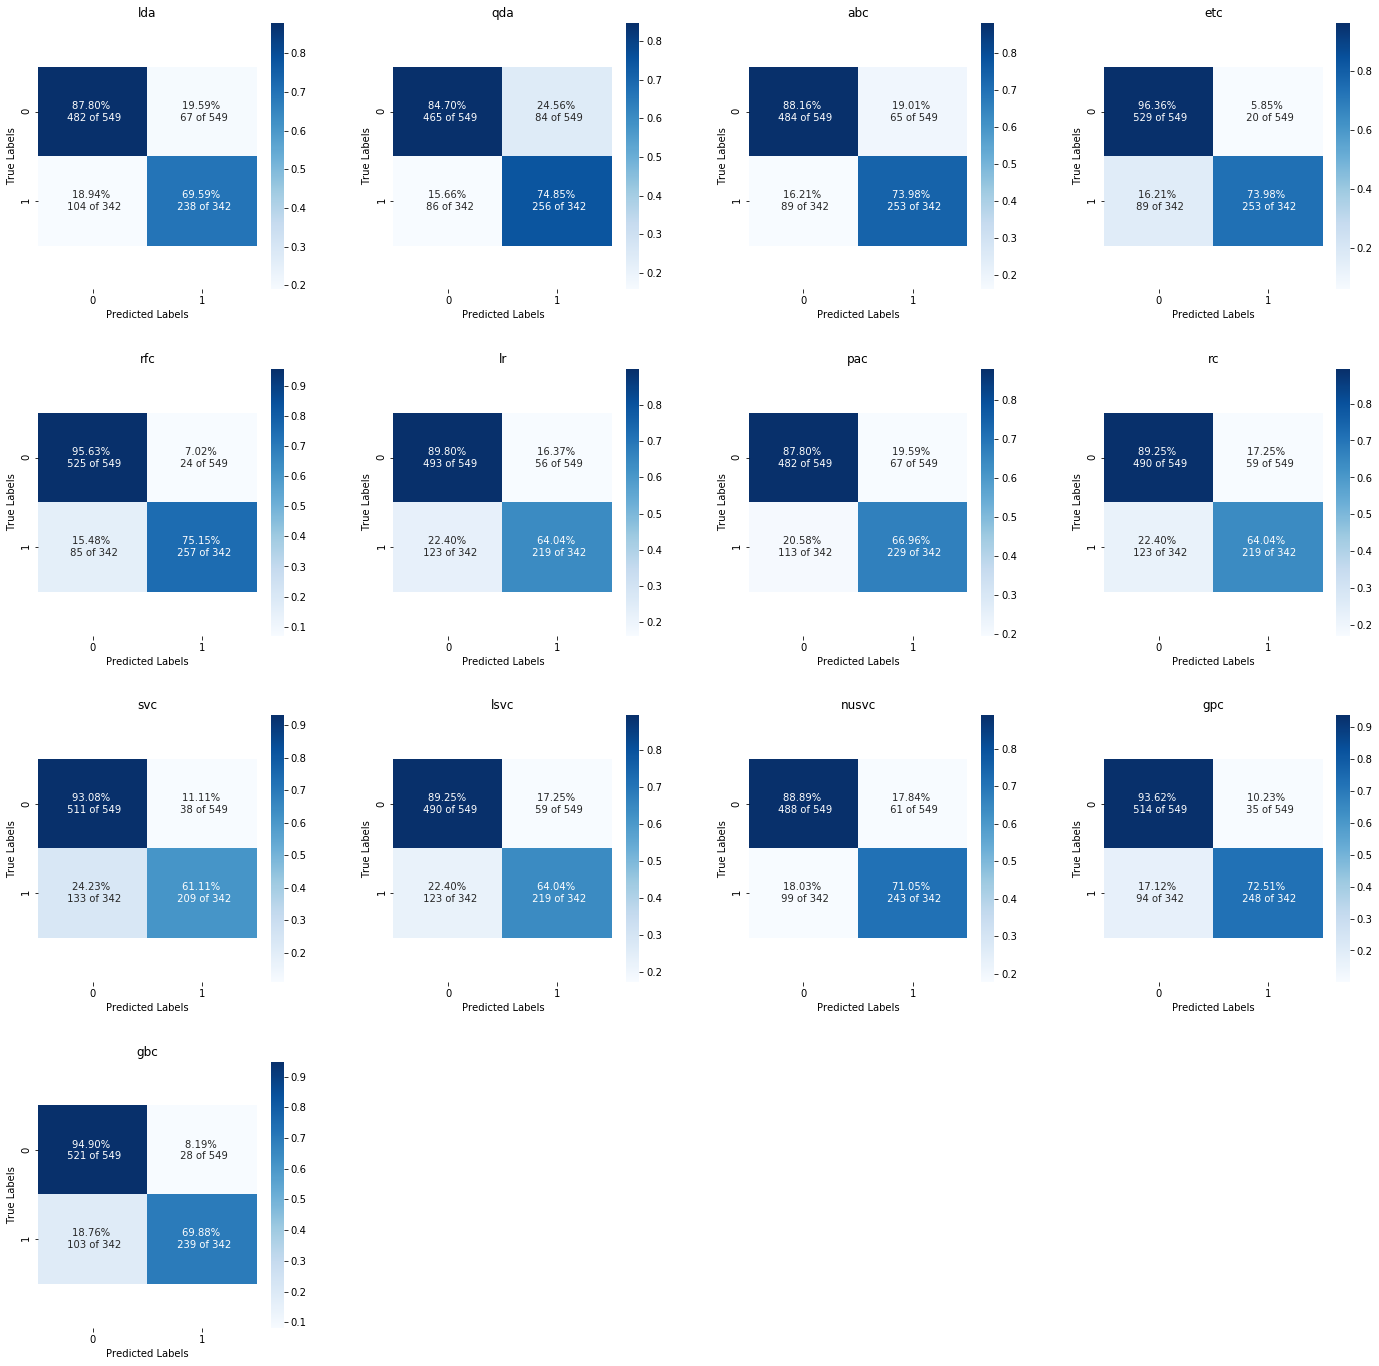

In [638]:
grd_n = len(base_models_surv)
grd_cols_n = 4
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(6 * grd_cols_n, 6 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(base_models_surv):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

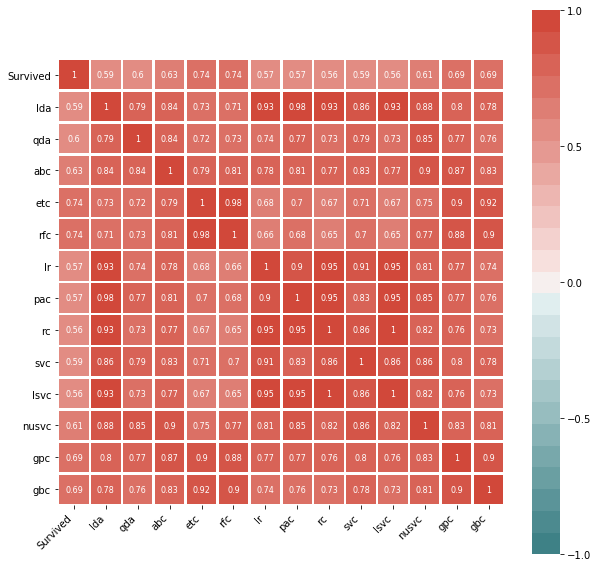

In [639]:
preds_base = base_models_predictions(base_models_surv, X)
preds_base = pd.concat([y.reset_index().drop(columns=['index']), preds_base], axis=1)
# data = pd.concat([pd.DataFrame(final_model_surv_st.predict_proba(X_test), columns=['final_pred_0', 'final_pred_1']), data], axis=1)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [640]:
corr_matrix.drop(index='Survived')

,Survived,lda,qda,abc,etc,rfc,lr,pac,rc,svc,lsvc,nusvc,gpc,gbc
lda,0.588181,1.000000,0.791811,0.835116,0.726289,0.706615,0.926136,0.977656,0.933450,0.858429,0.933450,0.877770,0.798328,0.782777
qda,0.596197,0.791811,1.000000,0.837441,0.715799,0.734746,0.735538,0.770356,0.727638,0.788391,0.727638,0.852773,0.774225,0.757072
abc,0.630751,0.835116,0.837441,1.000000,0.790542,0.810238,0.775177,0.812494,0.772510,0.826089,0.772510,0.901774,0.865489,0.832042
etc,0.741971,0.726289,0.715799,0.790542,1.000000,0.979262,0.678518,0.699385,0.671666,0.714235,0.671666,0.748977,0.900982,0.915097
rfc,0.740728,0.706615,0.734746,0.810238,0.979262,1.000000,0.660250,0.680234,0.653351,0.696629,0.653351,0.769914,0.880685,0.895232
lr,0.566768,0.926136,0.735538,0.775177,0.678518,0.660250,1.000000,0.900877,0.950212,0.905181,0.950212,0.810582,0.770588,0.735044
pac,0.565352,0.977656,0.770356,0.812494,0.699385,0.680234,0.900877,1.000000,0.949640,0.830138,0.949640,0.854450,0.772788,0.755771
rc,0.559343,0.933450,0.727638,0.772510,0.671666,0.653351,0.950212,0.949640,1.000000,0.860102,1.000000,0.818265,0.763334,0.728100
svc,0.588739,0.858429,0.788391,0.826089,0.714235,0.696629,0.905181,0.830138,0.860102,1.000000,0.860102,0.860573,0.800032,0.777097
lsvc,0.559343,0.933450,0.727638,0.772510,0.671666,0.653351,0.950212,0.949640,1.000000,0.860102,1.000000,0.818265,0.763334,0.728100


In [641]:
cm = corr_matrix.drop(index='Survived')
corr_sc = {}
for k in base_models_surv_dic.keys():
    corr_sc[k] = (cm[k].sum() - 1) / len(cm.index)
    
df_base_models_corr_sc = pd.concat([cm['Survived'], pd.Series(corr_sc)], axis=1)
df_base_models_corr_sc.sort_values(by=0, ascending=False)

,Survived,0
lda,0.588181,0.780602
pac,0.565352,0.765648
nusvc,0.614853,0.765394
abc,0.630751,0.756263
rc,0.559343,0.756021
lsvc,0.559343,0.756021
gpc,0.690899,0.754725
lr,0.566768,0.753717
svc,0.588739,0.752077
gbc,0.687720,0.739442


In [642]:
#opt
# base_models_surv_dic = {'rfc':rfc,'lr':lr,'pac':pac,'svc':svc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc,'qda':qda}

In [643]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rfc':rfc,'lr':lr,'pac':pac,'rc':rc,'svc':svc,'lsvc':lsvc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc}

In [644]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

In [645]:
def train_final_models(models, X, y, score, cv_folds=5):
    scores = {}
    for m in models:
        model_st = ens.StackingClassifier(estimators=base_models_surv,
                                          final_estimator=m[1],
                                          cv=cv_folds, 
                                          stack_method='predict', 
                                          n_jobs=-1)
        res = cv_rep(model_st, X, y, cv, scoring)
        scores[m[0]] = res.loc['mean_test', score]
    return pd.DataFrame(scores, index=['Test_score'])

In [646]:
train_final_models(base_models_surv, X, y, cv_folds=5, score='accuracy')

,lda,qda,abc,etc,rfc,lr,pac,rc,svc,lsvc,nusvc,gpc,gbc
Test_score,0.796175,0.663713,0.795243,0.798041,0.798507,0.798974,0.739739,0.796175,0.807369,0.796642,0.801772,0.801772,0.796642


In [647]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rfc':rfc,'lr':lr,'pac':pac,'rc':rc,'svc':svc,'lsvc':lsvc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc}

In [648]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

In [649]:
train_final_models(base_models_surv, X, y, cv_folds=5, score='accuracy')

,rfc,lr,pac,svc,nusvc,gpc,gbc,qda
Test_score,0.794776,0.805504,0.740672,0.803638,0.803172,0.801772,0.798974,0.78125


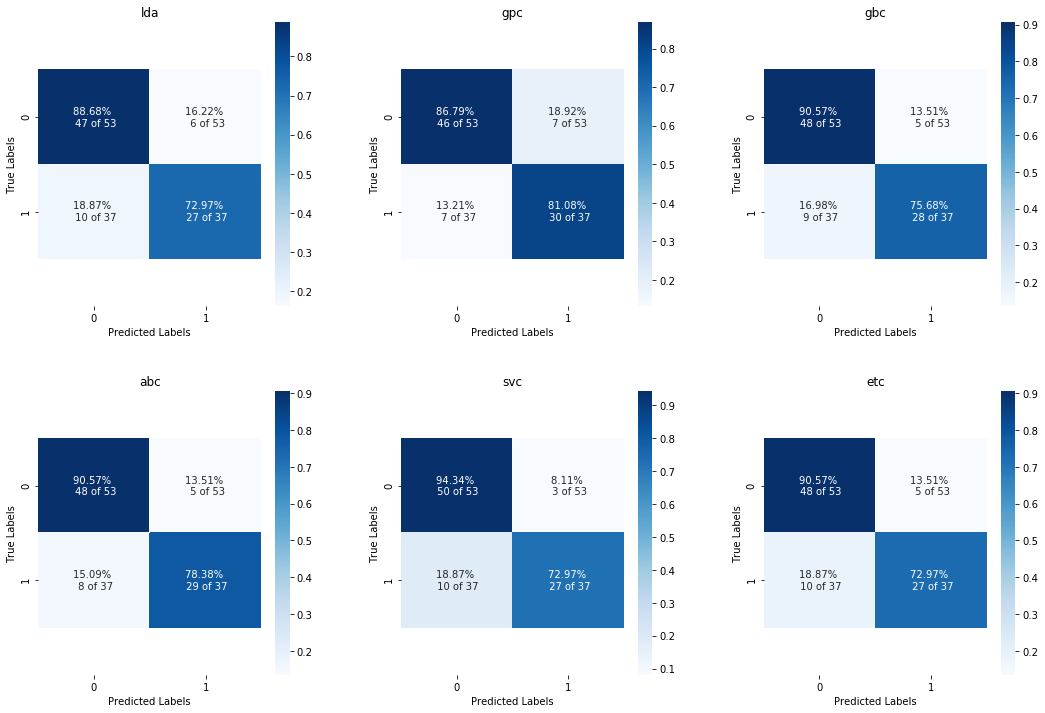

In [444]:
grd_n = len(fin_models_surv)
grd_cols_n = 3
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(6 * grd_cols_n, 6 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(fin_models_surv):
    lbl, model = m
    plot_confusion_matrix(model, X_test, y_test, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

In [440]:
fin_models_surv_dic = {'lda':lda,'gpc':gpc,'gbc':gbc,'abc':abc,'svc':svc,'etc':etc}

In [441]:
fin_models_surv = [(k,fin_models_surv_dic[k]) for k in fin_models_surv_dic.keys()]

In [398]:
pred_test = final_model_surv_vt.predict_proba(X_test)
len(pred_test[:,1]>0.9)

90